# target encoder & ohe & xDeepFM - basic

In [1]:
%load_ext autoreload
%autoreload 2

import os
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath('..'))
# ---------------------------------
from time import sleep
import numpy as np
import pandas as pd
import scipy
import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Activation
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.metrics import roc_auc_score

from hyperopt import hp
# ---------------------------------
from tools import CV, Tuning, CVGetScore, IdxValEncoder, xdeepfm, CyclicLR, MaxLrFinder
# ---------------------------------
from tools import focal_loss, gelu, mish
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({'focal_loss': focal_loss()})
get_custom_objects().update({'mish': mish})
get_custom_objects().update({'gelu': gelu})

In [2]:
train_df = pd.read_csv('../data/train.csv', index_col='id')
test_df = pd.read_csv('../data/test.csv', index_col='id')

# ord_5
for i in range(2):
    train_df[f'ord_5_{i}'] = train_df['ord_5'].str[i]
    test_df[f'ord_5_{i}'] = test_df['ord_5'].str[i]

# null
train_df['null'] = train_df.isna().sum(axis=1)
test_df['null'] = test_df.isna().sum(axis=1)

for col in test_df.columns:
    train_df[col].fillna('isnull', inplace=True)
    test_df[col].fillna('isnull', inplace=True)

# target
target = train_df['target']
y_train = target.values

# drop
train_df.drop(['target', 'ord_5'], axis=1, inplace=True)
test_df.drop(['ord_5'], axis=1, inplace=True)

In [3]:
feature_col = train_df.columns

bin_col = ['null']

class_col = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4',
             'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4',
             'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9',
             'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4',
             'day', 'month', 'ord_5_0', 'ord_5_1']

In [4]:
# for col in bin_col:
#     map_dict = dict(zip(train_df[col].unique(), [0., 1.]))
#     train_df[col] = train_df[col].map(map_dict)
#     test_df[col] = test_df[col].map(map_dict)

In [5]:
ecd = IdxValEncoder(feature_col, bin_col=bin_col, class_col=class_col)
ecd.fit(train_df, verbose=1)

600000it [00:27, 22162.04it/s]


In [6]:
ecd.fit(test_df, verbose=1)

400000it [00:18, 22174.31it/s]


In [7]:
idx, val = ecd.transform(train_df, verbose=1)
idx_test, val_test = ecd.transform(test_df, verbose=1)

600000it [00:29, 20351.89it/s]
400000it [00:18, 21211.25it/s]


# Search Max LR

In [11]:
%%time

tf.keras.backend.clear_session()

batch_size = 8192
epochs = 5
nflold = 5

model_param = {'vocabulary_size':ecd.get_vocabulary(), 
               'feature_number': len(feature_col),
               'activation': 'sigmoid',
               'metrics': ['AUC'],
               'optimizer': 'Adam',
               'loss': 'binary_crossentropy', 
               'num_cin_layer': 4, 'num_cin_size': 256,
               'split_half':True}

mf = MaxLrFinder(1e-6, 1e-2, epochs=epochs, batch_size=batch_size, sample_length=train_df.shape[0]*((nflold-1)/nflold))
fit_param = {'batch_size': batch_size, 'epochs':epochs, 'verbose': 1, 'callbacks':[mf], 'workers': 16}

model = xdeepfm(**model_param)

cv = CV(model, nflold)

score = cv.fit(x=[idx, val],
               y=y_train, 
               metrics_func=roc_auc_score,
               split_method=StratifiedKFold,
               fit_params=fit_param,
               eval_param={'batch_size':batch_size},
               use_proba=False, 
               verbose=True,
               fit_use_valid=True)


Train on 479999 samples, validate on 120001 samples
Epoch 1/5
479999/479999 [==============================] - 15s 31us/sample - loss: 0.6944 - AUC: 0.4967 - val_loss: 0.6916 - val_AUC: 0.4982
Epoch 2/5
479999/479999 [==============================] - 11s 23us/sample - loss: 0.6822 - AUC: 0.4969 - val_loss: 0.6637 - val_AUC: 0.4940
Epoch 3/5
479999/479999 [==============================] - 11s 23us/sample - loss: 0.6016 - AUC: 0.4989 - val_loss: 0.4904 - val_AUC: 0.4967
Epoch 4/5
479999/479999 [==============================] - 11s 23us/sample - loss: 0.4498 - AUC: 0.6732 - val_loss: 0.4017 - val_AUC: 0.7807
Epoch 5/5
479999/479999 [==============================] - 11s 23us/sample - loss: 0.3979 - AUC: 0.7854 - val_loss: 0.4011 - val_AUC: 0.7812
folds 0 is done, score is 0.7812718029719459
Train on 479999 samples, validate on 120001 samples
Epoch 1/5
479999/479999 [==============================] - 14s 30us/sample - loss: 0.6916 - AUC: 0.4981 - val_loss: 0.6844 - val_AUC: 0.4953
Epoch

In [12]:
tf.keras.backend.clear_session()

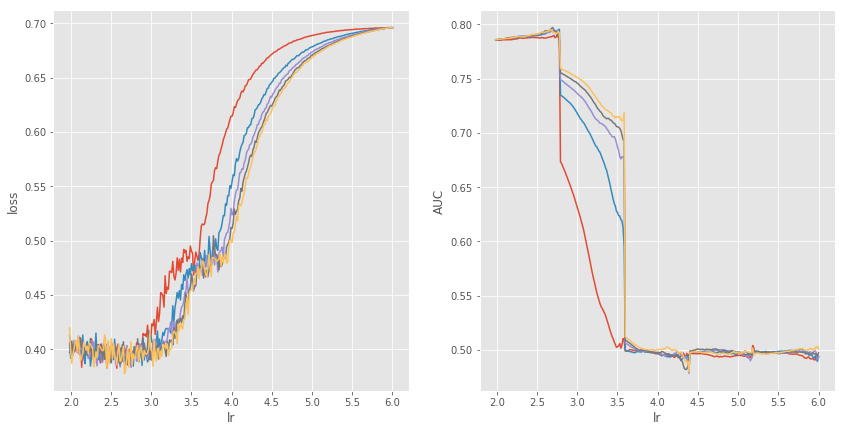

In [13]:
mf.plot(True)

# fit one

In [17]:
%%time

batch_size = 8192
epochs = 100
nflod = 5

model_param = {'vocabulary_size':ecd.get_vocabulary(), 
               'feature_number': len(feature_col),
               'activation': 'sigmoid',
               'metrics': ['AUC'],
               'optimizer': 'Adam',
               'loss': 'binary_crossentropy'}

clr = CyclicLR(base_lr=1e-5,
               max_lr=1e-3, 
               step_size=int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
               mode='exp_range',
               gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', patience=5, mode='max', restore_best_weights=True)

fit_param = {'batch_size': batch_size, 'epochs':epochs, 'verbose': 1, 'callbacks':[es, clr]}

model = xdeepfm(**model_param)

cv = CV(model, nflod)

score = cv.fit(x=[idx, val],
               y=y_train, 
               metrics_func=roc_auc_score,
               split_method=StratifiedKFold,
               fit_params=fit_param,
               eval_param={'batch_size':batch_size},
               use_proba=False, 
               verbose=True,
               fit_use_valid=True)

tf.keras.backend.clear_session()

Train on 479999 samples, validate on 120001 samples
Epoch 1/100
479999/479999 [==============================] - 6s 13us/sample - loss: 0.6523 - AUC: 0.5021 - val_loss: 0.5653 - val_AUC: 0.5335
Epoch 2/100
479999/479999 [==============================] - 4s 8us/sample - loss: 0.4902 - AUC: 0.5521 - val_loss: 0.4614 - val_AUC: 0.7144
Epoch 3/100
479999/479999 [==============================] - 4s 8us/sample - loss: 0.4258 - AUC: 0.7476 - val_loss: 0.4012 - val_AUC: 0.7805
Epoch 4/100
479999/479999 [==============================] - 4s 8us/sample - loss: 0.3935 - AUC: 0.7921 - val_loss: 0.3971 - val_AUC: 0.7868
Epoch 5/100
479999/479999 [==============================] - 4s 8us/sample - loss: 0.3899 - AUC: 0.7973 - val_loss: 0.3972 - val_AUC: 0.7866
Epoch 6/100
479999/479999 [==============================] - 4s 8us/sample - loss: 0.3882 - AUC: 0.7997 - val_loss: 0.3979 - val_AUC: 0.7859
Epoch 7/100
479999/479999 [==============================] - 4s 8us/sample - loss: 0.3870 - AUC: 0.80

In [18]:
score

0.7875319555651991

# Tuning

In [19]:
batch_size = 8192
epochs = 100
nflod = 5

# fit param

clr = CyclicLR(base_lr=1e-5,
               max_lr = 1e-3, 
               step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
               mode='exp_range',
               gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                      patience=3,
                                      mode='max',
                                      restore_best_weights=True)

fit_param = {
    'batch_size': batch_size, 
    'epochs':epochs, 
    'verbose': 0,
    'callbacks':[es, clr]
}

cv_fit_param = {'fit_params': fit_param, 
                'eval_param': {'batch_size':batch_size},
                'use_proba':False, 
                'fit_use_valid': True}

# model_fix_param & model_search_space
model_fix_param = {'vocabulary_size':ecd.get_vocabulary(), 
                   'feature_number': len(feature_col),
                   'activation': 'sigmoid',
                   'metrics': ['AUC'],
                   'k': 5,
                   'deep_use_bn': False,
                   'optimizer': 'Adam',
                   'split_half':True,
                   'num_deep_layer': 2}

ss = {
    'loss': (hp.choice, ('focal_loss', 'binary_crossentropy')), 
    'deep_activation': (hp.choice, ('mish', 'gelu')),
    'num_neuron': (hp.choice, (64, 128, 256)),
    'l2_deep': (hp.loguniform, (-15, -6)),
    'deep_dropout': (hp.uniform, (0.1, 0.4)),
    'num_cin_layer': (hp.choice, (1, 2, 3, 4)),
    'num_cin_size': (hp.choice, (32, 64, 128, 256)),
    'cin_activation': (hp.choice, ('mish', 'gelu')),
    'l2_cin': (hp.loguniform, (-15, 0)),
    'cin_dropout': (hp.uniform, (0.1, 0.4)),
}

# cv get score
def neg_auc(y_true, y_pred):
    return - roc_auc_score(y_true, y_pred)

gs = CVGetScore(x=[idx, val],
                y=y_train, 
                metrics_func=neg_auc,
                split_method=StratifiedKFold,
                nfolds=nflod, 
                random_state=2333,
                model=xdeepfm, 
                cv_fit_params=cv_fit_param, 
                model_fix_params=model_fix_param, 
                model_search_space=ss)

tuning = Tuning(gs, verbose=1)
tuning.fmin(gs.GET_SEARCH_SPACE(), max_evals=100)

new best, eval 1, score -0.7878, param {'cin_activation': 'gelu', 'cin_dropout': 0.2057811773763612, 'deep_activation': 'mish', 'deep_dropout': 0.20858365242531457, 'l2_cin': 7.979700429019407e-06, 'l2_deep': 0.00111340891704806, 'loss': 'focal_loss', 'num_cin_layer': 3, 'num_cin_size': 32, 'num_neuron': 256}
new best, eval 3, score -0.7881, param {'cin_activation': 'mish', 'cin_dropout': 0.32949641474455055, 'deep_activation': 'gelu', 'deep_dropout': 0.26498769973408076, 'l2_cin': 0.13894034071012318, 'l2_deep': 7.894546073626839e-05, 'loss': 'focal_loss', 'num_cin_layer': 2, 'num_cin_size': 128, 'num_neuron': 256}
new best, eval 6, score -0.7881, param {'cin_activation': 'mish', 'cin_dropout': 0.2326420502543929, 'deep_activation': 'mish', 'deep_dropout': 0.25236626158562747, 'l2_cin': 0.08174554354988584, 'l2_deep': 0.00014460364694334098, 'loss': 'focal_loss', 'num_cin_layer': 3, 'num_cin_size': 32, 'num_neuron': 64}
new best, eval 22, score -0.7882, param {'cin_activation': 'mish'

{'cin_activation': 0,
 'cin_dropout': 0.2550548530047234,
 'deep_activation': 0,
 'deep_dropout': 0.33613923735133877,
 'l2_cin': 0.003304809456710979,
 'l2_deep': 0.00010687797599471418,
 'loss': 0,
 'num_cin_layer': 0,
 'num_cin_size': 3,
 'num_neuron': 0}

# Tuning 2

In [ ]:
batch_size = 8192
epochs = 100
nflod = 5

# fit param

clr = CyclicLR(base_lr=1e-5,
               max_lr = 1e-3, 
               step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
               mode='exp_range',
               gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                      patience=3,
                                      mode='max',
                                      restore_best_weights=True)

fit_param = {
    'batch_size': batch_size, 
    'epochs':epochs, 
    'verbose': 0,
    'callbacks':[es, clr]
}

cv_fit_param = {'fit_params': fit_param, 
                'eval_param': {'batch_size':batch_size},
                'use_proba':False, 
                'fit_use_valid': True}

# model_fix_param & model_search_space
model_fix_param = {'vocabulary_size':ecd.get_vocabulary(), 
                   'feature_number': len(feature_col),
                   'activation': 'sigmoid',
                   'metrics': ['AUC'],
                   'k': 5,
                   'deep_use_bn': False,
                   'optimizer': 'Adam',
                   'split_half':True,
                   'num_deep_layer': 2,
                   'cin_activation': 'linear'}

ss = {
    'loss': (hp.choice, ('focal_loss', 'binary_crossentropy')), 
    'deep_activation': (hp.choice, ('mish', 'gelu')),
    'num_neuron': (hp.choice, (64, 128, 256)),
    'l2_deep': (hp.loguniform, (-15, -6)),
    'deep_dropout': (hp.uniform, (0.1, 0.4)),
    'num_cin_layer': (hp.choice, (1, 2, 3, 4)),
    'num_cin_size': (hp.choice, (32, 64, 128, 256)),
    'l2_cin': (hp.loguniform, (-15, 0)),
    'cin_dropout': (hp.uniform, (0.1, 0.4)),
}

# cv get score
def neg_auc(y_true, y_pred):
    return - roc_auc_score(y_true, y_pred)

gs = CVGetScore(x=[idx, val],
                y=y_train, 
                metrics_func=neg_auc,
                split_method=StratifiedKFold,
                nfolds=nflod, 
                random_state=2333,
                model=xdeepfm, 
                cv_fit_params=cv_fit_param, 
                model_fix_params=model_fix_param, 
                model_search_space=ss)

tuning2 = Tuning(gs, verbose=1)
tuning2.fmin(gs.GET_SEARCH_SPACE(), max_evals=100)

new best, eval 1, score -0.7879, param {'cin_dropout': 0.3092258988440683, 'deep_activation': 'gelu', 'deep_dropout': 0.1402355684285091, 'l2_cin': 0.04040994580812637, 'l2_deep': 8.178813162024387e-06, 'loss': 'focal_loss', 'num_cin_layer': 1, 'num_cin_size': 64, 'num_neuron': 128}
new best, eval 5, score -0.7881, param {'cin_dropout': 0.29887194005576273, 'deep_activation': 'mish', 'deep_dropout': 0.34454928305899196, 'l2_cin': 0.22382862180320617, 'l2_deep': 7.47699066197892e-05, 'loss': 'focal_loss', 'num_cin_layer': 1, 'num_cin_size': 256, 'num_neuron': 256}
new best, eval 13, score -0.7882, param {'cin_dropout': 0.22349726824320137, 'deep_activation': 'gelu', 'deep_dropout': 0.3983325517009807, 'l2_cin': 0.007482119725859714, 'l2_deep': 0.001649155701362694, 'loss': 'binary_crossentropy', 'num_cin_layer': 2, 'num_cin_size': 32, 'num_neuron': 64}
new best, eval 19, score -0.7882, param {'cin_dropout': 0.14198582151160777, 'deep_activation': 'mish', 'deep_dropout': 0.26453148001195